# Project 1- Convolutional neural networks

In [4]:
import torch
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time

print("CUDA dostępna:", torch.cuda.is_available())
print("Nazwa GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Brak")


CUDA dostępna: True
Nazwa GPU: NVIDIA GeForce RTX 3070 Ti


In [6]:
cinic_mean = [0.47889522, 0.47227842, 0.43047404]
cinic_std = [0.24205776, 0.23828046, 0.25874835]

def read_paired_data_to_memory(cinic_directory, device):
    dataset = torchvision.datasets.ImageFolder(
                cinic_directory,
                transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean = cinic_mean, std = cinic_std)
                        ]))
    images = torch.stack([img for img, _ in dataset], dim =0).to(device)
    labels = torch.tensor(dataset.targets, dtype=torch.long, device= device)
    return list(zip(images, labels))
    

# Use this function if you do not have enough VRAM on your GPU
def make_datase_for_stream(cinic_directory, batch_size, device):
    return torchvision.datasets.ImageFolder(
                cinic_directory,
                transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean = cinic_mean, std = cinic_std)
                        ]))

In [7]:
def get_data_loader_for_memory(paired_data, batch_size):
    return torch.utils.data.DataLoader(paired_data
                                       , batch_size=batch_size
                                       , shuffle=True
                                       )

def get_data_loader_streamer(dataset, batch_size, num_workers = 16, pin_memory = True):
    return torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers = 16,
        pin_memory=True # Faster CPU ->  GPU transfer
    )

In [8]:
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

cinic_directory_train = './archive/train'
cinic_directory_test = './archive/test'
cinic_directory_valid = './archive/valid'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[LOG]: Device = {device.type}")

train_data = read_paired_data_to_memory(cinic_directory_train, device)
print(f"[LOG]: Train dataset loaded to {device}")

test_data = read_paired_data_to_memory(cinic_directory_test, device)
print(f"[LOG]: Test dataset loaded to {device}")

valid_data = read_paired_data_to_memory(cinic_directory_valid, device)
print(f"[LOG]: Valid dataset loaded to {device}")

[LOG]: Device = cuda
[LOG]: Train dataset loaded
[LOG]: Test dataset loaded
[LOG]: Valid dataset loaded


### SimpleCNN

`SimpleCNN` is a basic convolutional neural network designed for image classification tasks
It consists of two convolutional layers with ReLU activations and max pooling, followed by a simple fully connected (MLP) classifier. This model serves as a starting point for developing and comparing more advanced architectures in this project.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        # kernel_size = n - filter_size: n x n
        #  padding = n - size of extra border n pixels
        # stride = n - number of pixels the filter moves. up/down
        super().__init__()
        #Conv part:
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding= 1, stride=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding= 2, stride=1)
        self.pool = nn.MaxPool2d(2,2)
        self.flatten = nn.Flatten()
        #MLP part:
        H = 8
        W = 8
        self.fc1 = nn.Linear(H * W * 32, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class MidCNN(nn.Module):
    def __init__(self):
        # kernel_size = n - filter_size: n x n
        #  padding = n - size of extra border n pixels
        # stride = n - number of pixels the filter moves. up/down
        super().__init__()
        #Conv part:
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding= 1, stride=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding= 1, stride=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size = 3, padding= 1, stride = 1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding= 2, stride=1)
        
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.flatten = nn.Flatten()
        #MLP part:
        H = 16
        W = 16
        self.fc1 = nn.Linear(H * W * 128, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

        


In [45]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class ComplexCNN(nn.Module):
    def __init__(self, dropout_rate=0.4):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)  # 32 -> 16

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)  # 16 -> 8

        self.dropout = nn.Dropout(p=dropout_rate)
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(128 * 8 * 8, 128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        
        self.fc2 = nn.Linear(128, 64)
        self.bn_fc2 = nn.BatchNorm1d(64)

        self.fc3 = nn.Linear(64, 10)

        self._initialize_weights()

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(F.relu(self.bn2(self.conv2(x))))
        x = self.pool2(F.relu(self.bn3(self.conv3(x))))
        
        x = self.flatten(x)
        x = self.dropout(F.relu(self.bn_fc1(self.fc1(x))))
        x = self.dropout(F.relu(self.bn_fc2(self.fc2(x))))
        x = self.fc3(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)


In [44]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class ExtremeCNN(nn.Module):
    def __init__(self, dropout_rate=0.4):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)  # 32 -> 16

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)  # 16 -> 8

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)  # 8 -> 4

        self.dropout = nn.Dropout(p=dropout_rate)
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(256 * 4 * 4, 128)
        self.bn_fc1 = nn.BatchNorm1d(128)

        self.fc2 = nn.Linear(128, 64)
        self.bn_fc2 = nn.BatchNorm1d(64)

        self.fc3 = nn.Linear(64, 10)

        self._initialize_weights()

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool2(F.relu(self.bn4(self.conv4(x))))
        x = self.pool3(F.relu(self.bn5(self.conv5(x))))

        x = self.flatten(x)
        x = self.dropout(F.relu(self.bn_fc1(self.fc1(x))))
        x = self.dropout(F.relu(self.bn_fc2(self.fc2(x))))
        x = self.fc3(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)


In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def train_one_epoch(model, loader, optimizer, loss_fun, device, f_gradient_cliping = False):
    model.train()
    total_loss = 0
    batch_losses  = []
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad() # reset gradients before new epoch !!!!!!!!!!! very important !!!!!!!!!!!
        outputs = model(inputs)
        loss = loss_fun(outputs, labels) # calculate loss_function
        loss.backward() # gradient propagation
        
        if f_gradient_cliping:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        
        optimizer.step() # gradient actualization
        loss_value = loss.item()
        total_loss += loss_value
        batch_losses.append(loss_value)
    
    avg_loss = total_loss / len(loader)
    return avg_loss, batch_losses

def evaluate(model, loader, loss_fun, device):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0
    batch_losses = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fun(outputs, labels)
            loss_val = loss.item()
            total_loss += loss_val
            batch_losses.append(loss_val)

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    accuracy = 100 * correct / total
    avg_loss = total_loss / len(loader)
    
    return avg_loss, accuracy, batch_losses

In [37]:
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix, roc_curve

def score_model(y_true, y_pred, name = "Model"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
    print(f"Metrics for {name}:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.2f}")
    print(f"Classification Report:\n{classification_report(y_true, y_pred)}")



In [38]:
def training_details_plot(batch_loses_train, batch_loses_validate, smoothness = 0.9):
    def smooth_curve(data, weight):
        smoothed = []
        last = data[0]
        for point in data:
            smoothed_val = last * weight + (1 - weight) * point
            smoothed.append(smoothed_val)
            last = smoothed_val
        return smoothed
    train_loses = smooth_curve(batch_loses_train, smoothness)
    valid_loses = smooth_curve(batch_loses_validate, smoothness)

    plt.figure(figsize=(10, 4))
    plt.plot(train_loses, label="Train Loss")
    plt.plot(valid_loses, label="Validation Loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Training loss per iteration")
    plt.grid(True)
    plt.show()


In [48]:
model = ComplexCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fun = nn.CrossEntropyLoss()

all_batch_losses_train = []
all_batch_losses_valid = []

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(1, 10):  # np. 10 epok
    train_loss, batch_losses_train = train_one_epoch(model, get_data_loader_for_memory(train_data, 128), optimizer, loss_fun, device)
    val_loss, val_acc, batch_losses_valid = evaluate(model, get_data_loader_for_memory(valid_data, 128), loss_fun, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    all_batch_losses_train.extend(batch_losses_train)
    all_batch_losses_valid.extend(batch_losses_valid)

    print(f"[Epoch {epoch}] Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}, Val acc: {val_acc:.2f}%")

[Epoch 1] Train loss: 1.6019, Val loss: 1.2718, Val acc: 54.23%
[Epoch 2] Train loss: 1.2836, Val loss: 1.1173, Val acc: 60.14%
[Epoch 3] Train loss: 1.1598, Val loss: 1.1196, Val acc: 59.39%
[Epoch 4] Train loss: 1.0726, Val loss: 1.0513, Val acc: 62.54%
[Epoch 5] Train loss: 0.9931, Val loss: 0.9680, Val acc: 65.31%
[Epoch 6] Train loss: 0.9261, Val loss: 0.9849, Val acc: 64.92%
[Epoch 7] Train loss: 0.8524, Val loss: 0.9543, Val acc: 65.92%
[Epoch 8] Train loss: 0.7938, Val loss: 0.9948, Val acc: 65.31%
[Epoch 9] Train loss: 0.7299, Val loss: 0.9469, Val acc: 66.82%


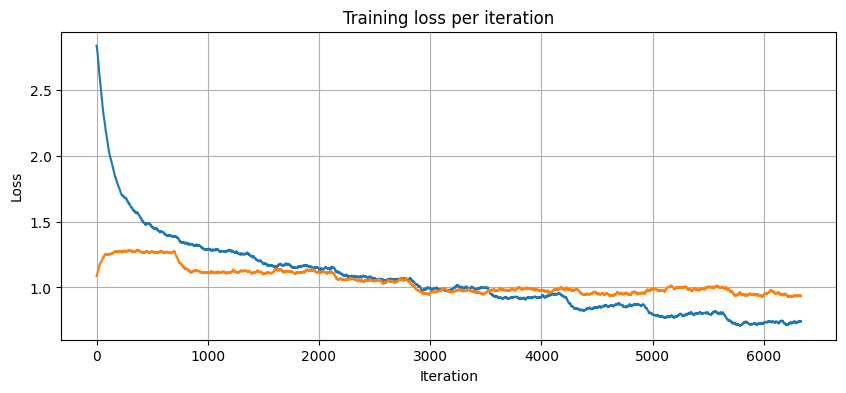

In [49]:
training_details_plot(all_batch_losses_train, all_batch_losses_valid, smoothness=0.98)


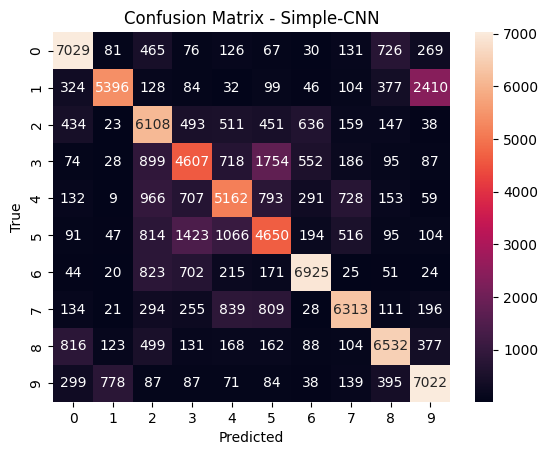

Metrics for Simple-CNN:
Accuracy: 0.66
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.78      0.76      9000
           1       0.83      0.60      0.70      9000
           2       0.55      0.68      0.61      9000
           3       0.54      0.51      0.52      9000
           4       0.58      0.57      0.58      9000
           5       0.51      0.52      0.52      9000
           6       0.78      0.77      0.78      9000
           7       0.75      0.70      0.73      9000
           8       0.75      0.73      0.74      9000
           9       0.66      0.78      0.72      9000

    accuracy                           0.66     90000
   macro avg       0.67      0.66      0.66     90000
weighted avg       0.67      0.66      0.66     90000



In [ ]:
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in get_data_loader_for_memory(test_data, 128):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

score_model(all_labels, all_preds, "Simple-CNN")